Obs shape: (21, 80, 80)


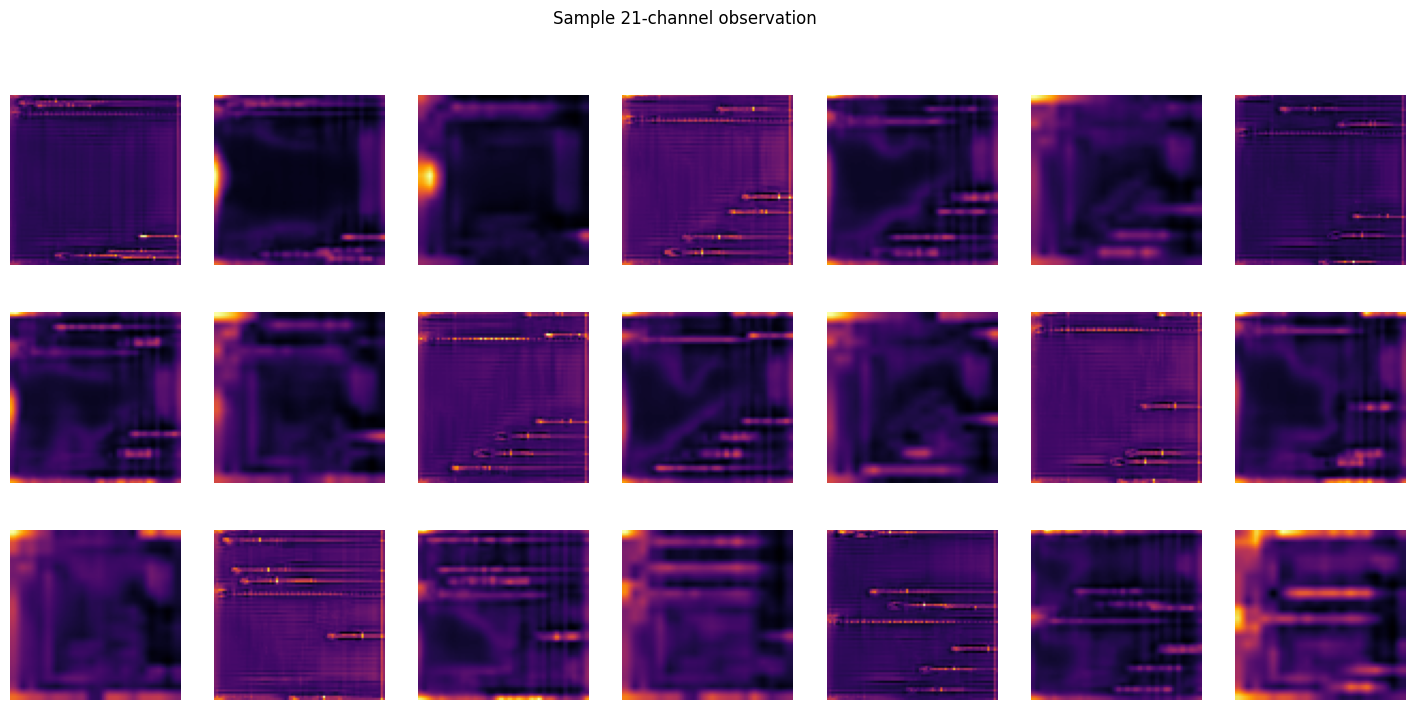

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN


# -----------------------------
# 1. Encoder
# -----------------------------
class YOLOFeatureEncoder(nn.Module):
    def __init__(self, weight_path="./best.pt"):
        super().__init__()
        self.yolo = YOLO(weight_path).model
        self.features = {}

        # register hooks for P3, P4, P5
        self.yolo.model[15].register_forward_hook(self._hook("P3"))
        self.yolo.model[18].register_forward_hook(self._hook("P4"))
        self.yolo.model[21].register_forward_hook(self._hook("P5"))

        self.transform = transforms.Compose([
            transforms.Resize((640, 640)),
            transforms.ToTensor()
        ])

    def _hook(self, name):
        def fn(module, input, output):
            self.features[name] = output
        return fn

    def forward(self, img_path):
        img = Image.open(img_path).convert("RGB")
        x = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            _ = self.yolo(x)  # run full YOLO forward, hooks will populate features

        p3, p4, p5 = self.features["P3"], self.features["P4"], self.features["P5"]

        # collapse channels
        p3c = p3.mean(dim=1, keepdim=True)
        p4c = p4.mean(dim=1, keepdim=True)
        p5c = p5.mean(dim=1, keepdim=True)

        # resize p4, p5 to (80, 80)
        p4c = F.interpolate(p4c, size=(80, 80), mode="bilinear")
        p5c = F.interpolate(p5c, size=(80, 80), mode="bilinear")

        return torch.cat([p3c, p4c, p5c], dim=1)  # [1, 3, 80, 80]



# -----------------------------
# 2. Trading Env
# -----------------------------
class TradingEnv(gym.Env):
    def __init__(self, encoder, image_paths_by_tf):
        super().__init__()
        self.encoder = encoder
        self.image_paths_by_tf = image_paths_by_tf
        self.current_step = 10
        self.max_step = min(len(v) for v in image_paths_by_tf.values())

        # 3 actions
        self.action_space = spaces.Discrete(3)
        
        self.observation_space = spaces.Box(
            low=0.0, high=1.0, shape=(21, 80, 80), dtype=np.float32
        )


    def _get_state(self):
        feats_now = []
        for tf, imgs in self.image_paths_by_tf.items():
            now = self.encoder(imgs[self.current_step])
            feats_now.append(now)
        now_cat = torch.cat(feats_now, dim=1)   # [1,21,80,80]
        return now_cat.squeeze(0).numpy()       # [21,80,80]


    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 10
        obs = self._get_state()
        info = {}
        return obs, info


    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_step
        reward = np.random.randn() 

        obs = self._get_state()
        terminated = done      # end of episode
        truncated = False      # for now, no truncation
        info = {}

        return obs, reward, terminated, truncated, info



# -----------------------------
# 3. Load images
# -----------------------------
base_path = "../dataset"
timeframes = ["1m","3m","5m","15m","1h","4h","1d"]

image_paths_by_tf = {}
for tf in timeframes:
    imgs = sorted(glob.glob(os.path.join(base_path, tf, "images", "*")))
    image_paths_by_tf[tf] = imgs[:1000]  # cap at 1000 per tf


# -----------------------------
# 4. Instantiate env + sanity check obs
# -----------------------------
encoder = YOLOFeatureEncoder("./best.pt")
env = TradingEnv(encoder=encoder, image_paths_by_tf=image_paths_by_tf)

obs, info = env.reset()
print("Obs shape:", obs.shape)


# plot sample obs grid
fig, axes = plt.subplots(3, 7, figsize=(18, 8))  # 21 = 3x7
for i, ax in enumerate(axes.flat):
    if i < 21:
        ax.imshow(obs[i], cmap="inferno")
        ax.axis("off")
plt.suptitle("Sample 21-channel observation")
plt.show()



# -----------------------------
# 5. Train RL agent (DQN)
# -----------------------------
dqn_model = DQN(
    "CnnPolicy",
    env,
    verbose=1,
    buffer_size=1000,
    learning_starts=100,
    train_freq=4,
    target_update_interval=500,
    batch_size=32,
    learning_rate=1e-4,
    exploration_fraction=0.1,
    policy_kwargs=dict(normalize_images=False)  # <--- key fix
)


dqn_model.learn(total_timesteps=1)
